# STOCK MARKET EDA

## 1. Importing libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid")

## 2. Data Loading

In [6]:
df = pd.read_csv(r'D:\Unified Mentor intern\project 4\stocks.csv', parse_dates=['Date'])
print("Available columns:", df.columns.tolist())
df.sort_values('Date', inplace=True)
df.head()

Available columns: ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
62,MSFT,2023-02-07,260.529999,268.769989,260.079987,267.559998,266.891510,50841400
186,GOOG,2023-02-07,103.629997,108.669998,103.547997,108.040001,108.040001,33738800
124,NFLX,2023-02-07,358.510010,364.179993,354.179993,362.950012,362.950012,6289400
187,GOOG,2023-02-08,102.690002,103.580002,98.455002,100.000000,100.000000,73546000


## 3. Quick Data Check

In [43]:
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print(df.info())
print("Missing values per column:\n", df.isna().sum())

Rows: 248
Columns: ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Return']
<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 0 to 247
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ticker     248 non-null    object        
 1   Date       248 non-null    datetime64[ns]
 2   Open       248 non-null    float64       
 3   High       248 non-null    float64       
 4   Low        248 non-null    float64       
 5   Close      248 non-null    float64       
 6   Adj Close  248 non-null    float64       
 7   Volume     248 non-null    int64         
 8   Return     244 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 19.4+ KB
None
Missing values per column:
 Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Return       4
dtype: int64


## 4. EDA

### (i) Plot the Close price time series for each company

Available columns: ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


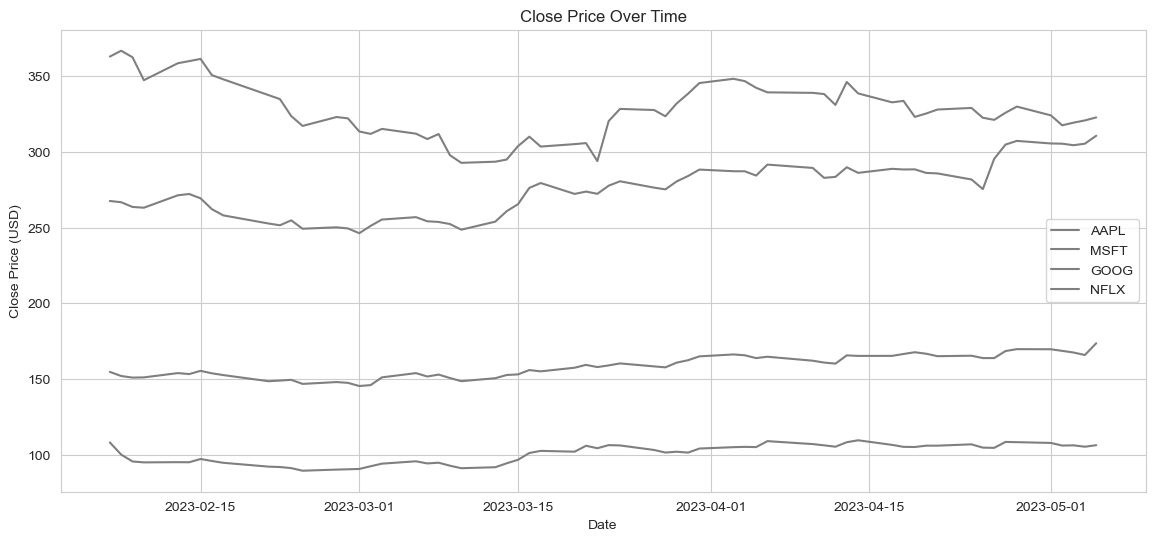

In [13]:
print("Available columns:", df.columns.tolist())
company_column = 'Ticker'  
companies = df[company_column].unique()
colors = {'Apple':'tab:blue', 'Microsoft':'tab:green', 'Netflix':'tab:red', 'Google':'tab:orange'}
plt.figure(figsize=(14,6))
for c in companies:
    sub = df[df[company_column]==c]  # Use the same column name consistently
    plt.plot(sub['Date'], sub['Close'], label=c, color=colors.get(c,'tab:gray'))
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

### (ii) Plot log returns and histograms

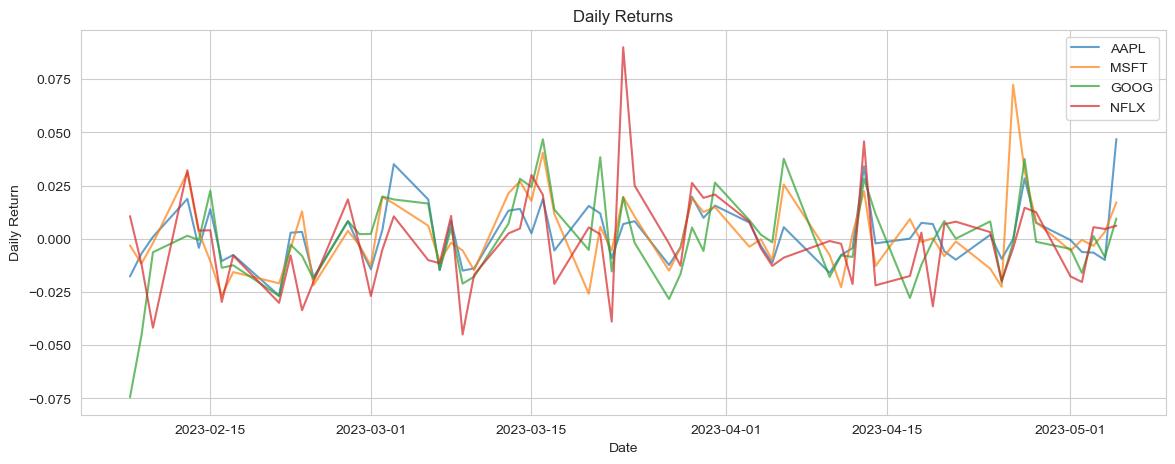

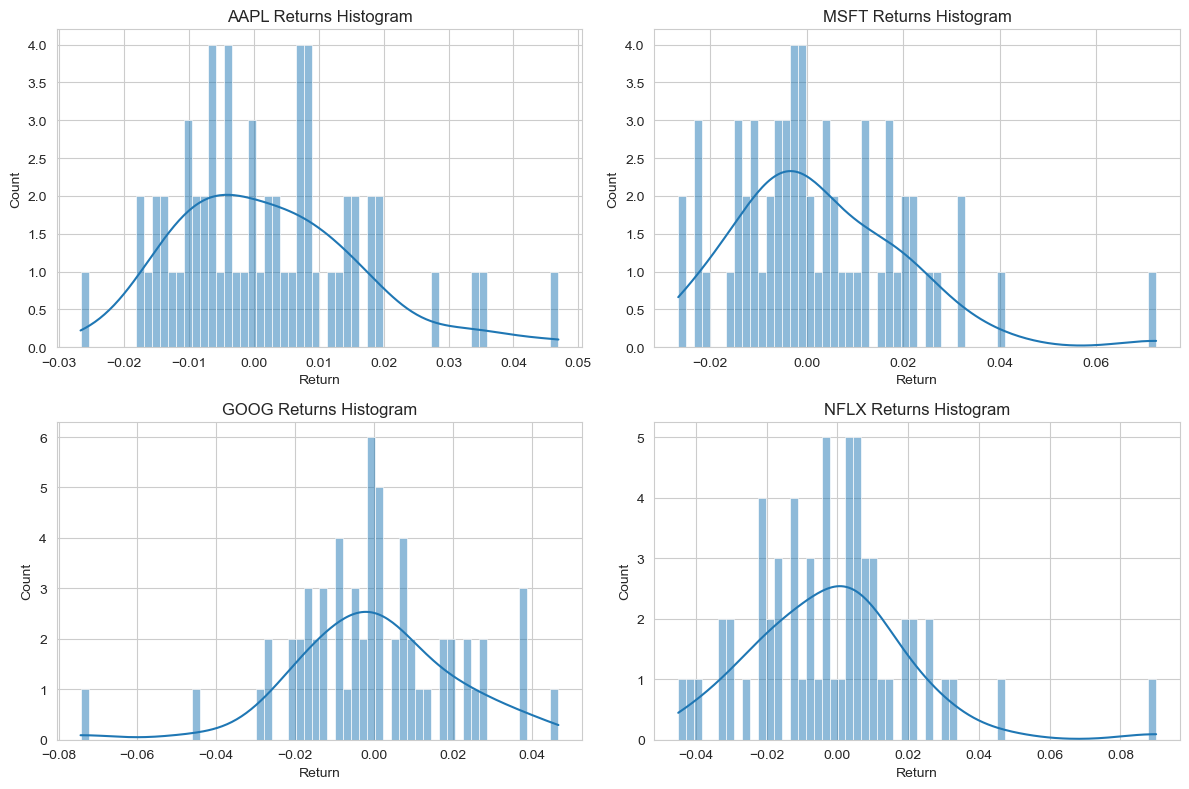

In [16]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change()
plt.figure(figsize=(14,5))
for c in companies:
    sub = df[df['Ticker']==c]
    plt.plot(sub['Date'], sub['Return'], label=c, alpha=0.7)
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
for i,c in enumerate(companies):
    plt.subplot(2,2,i+1)
    sns.histplot(df[df['Ticker']==c]['Return'].dropna(), bins=60, kde=True)
    plt.title(f"{c} Returns Histogram")
plt.tight_layout()
plt.show()

### (iii) Rolling moving averages

Available columns: ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Return']
Available tickers: ['AAPL' 'MSFT' 'GOOG' 'NFLX']
Using 'AAPL' instead


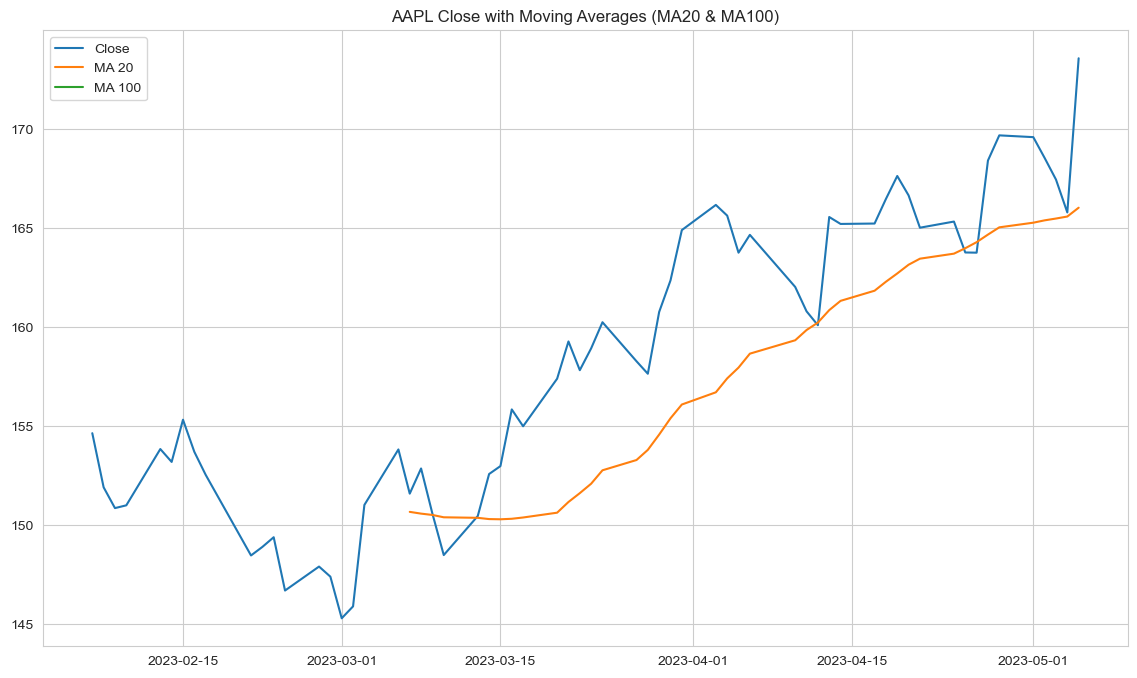

In [22]:
window_short = 20
window_long = 100
print("Available columns:", df.columns.tolist())
if 'Ticker' in df.columns:
    print("Available tickers:", df['Ticker'].unique())
c = 'Apple' 
if 'Ticker' in df.columns and c not in df['Ticker'].unique() and len(df['Ticker'].unique()) > 0:
    c = df['Ticker'].unique()[0]
    print(f"Using '{c}' instead")
plt.figure(figsize=(14,8))
sub = df[df['Ticker']==c].copy()
if len(sub) > 0:
    sub['MA20'] = sub['Close'].rolling(window_short).mean()
    sub['MA100'] = sub['Close'].rolling(window_long).mean()
    plt.plot(sub['Date'], sub['Close'], label='Close', color='tab:blue')
    plt.plot(sub['Date'], sub['MA20'], label='MA 20', color='tab:orange')
    plt.plot(sub['Date'], sub['MA100'], label='MA 100', color='tab:green')
    plt.title(f"{c} Close with Moving Averages (MA20 & MA100)")
    plt.legend()
    plt.show()
else:
    print(f"No data found for ticker '{c}'")

## 5. Feature engineering 

In [25]:
def create_features(df, windows=[5,10,20,50]):
    df = df.copy()
    df['Return'] = df['Close'].pct_change()
    df['LogClose'] = np.log(df['Close'])
    # Lag features
    df['lag1'] = df['Close'].shift(1)
    df['lag2'] = df['Close'].shift(2)
    # Rolling features
    for w in windows:
        df[f'ma_{w}'] = df['Close'].rolling(window=w).mean()
        df[f'vol_{w}'] = df['Return'].rolling(window=w).std()
    # Date-based
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    # Target: next-day close
    df['target'] = df['Close'].shift(-1)
    return df
df_feat = df.groupby('Ticker').apply(lambda x: create_features(x)).reset_index(drop=True)
df_feat = df_feat.dropna(subset=['target'])  
df_feat.head()


,Ticker,Date,Open,High,Low,Close,Adj Close,Volume,Return,LogClose,...,vol_5,ma_10,vol_10,ma_20,vol_20,ma_50,vol_50,dayofweek,month,target
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600,NaN,5.041164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,151.919998
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100,-0.017653,5.023354,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,150.869995
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100,-0.006912,5.016419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,151.009995
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700,0.000928,5.017346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,153.850006
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000,0.018807,5.035978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,153.199997


## 6. Modeling approach

In [29]:
c = 'AAPL'
sub = df_feat[df_feat['Ticker']==c].copy()
sub = sub.dropna()
if len(sub) > 0:
    sub['pred_persist'] = sub['Close'] 
    mae_persist = mean_absolute_error(sub['target'], sub['pred_persist'])
    rmse_persist = math.sqrt(mean_squared_error(sub['target'], sub['pred_persist']))
    print("Baseline persistence MAE:", mae_persist, "RMSE:", rmse_persist)
else:
    print(f"No data available for ticker '{c}' after filtering and removing NaN values.")
    print("Available tickers:", df_feat['Ticker'].unique())

Baseline persistence MAE: 1.918182373046875 RMSE: 2.923339355089076


## 7. Model Training

In [38]:
features = ['lag1','lag2','ma_5','ma_10','ma_20','vol_5','vol_10','dayofweek','month']
try:
    print("DataFrame info:", df_feat.shape, "Available tickers:", df_feat['Ticker'].unique())
except NameError:
    print("df_feat is not defined! Please load your data first.")
def train_models_for_company(df_feat, ticker):
    print(f"Starting analysis for ticker: {ticker}")
    if ticker not in df_feat['Ticker'].unique():
        print(f"Ticker '{ticker}' not found! Available: {df_feat['Ticker'].unique()}")
        return None
    data = df_feat[df_feat['Ticker']==ticker].copy().dropna()
    print(f"Data shape after filtering and dropping NA: {data.shape}")
    if len(data) < 2:
        print(f"Insufficient data for {ticker}.")
        return None
    required_cols = features + ['target']
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        return None
    X = data[features]
    y = data['target']
    split_idx = int(len(data)*0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    print(f"Training/Testing shapes: {X_train.shape}, {X_test.shape}")
    try:
        from sklearn.linear_model import LinearRegression
        from sklearn.ensemble import RandomForestRegressor
        lr = LinearRegression().fit(X_train, y_train)
        rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        y_pred_rf = rf.predict(X_test)
        print("Models fitted successfully!")
        return {
            'lr': {'model': lr, 'y_test': y_test, 'y_pred': y_pred_lr},
            'rf': {'model': rf, 'y_test': y_test, 'y_pred': y_pred_rf},
            'split_idx': split_idx,
            'data': data
        }
    except Exception as e:
        print(f"Error during model fitting: {e}")
        return None
res = train_models_for_company(df_feat, 'AAPL')
if res:
    print(f"Results: LR and RF models trained, test set size: {len(res['lr']['y_test'])}")

DataFrame info: (244, 23) Available tickers: ['AAPL' 'GOOG' 'MSFT' 'NFLX']
Starting analysis for ticker: AAPL
Data shape after filtering and dropping NA: (11, 23)
Training/Testing shapes: (8, 9), (3, 9)
Models fitted successfully!
Results: LR and RF models trained, test set size: 3


## 8. Model evaluation 

In [40]:
def eval_preds(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE%': mape}
print("Linear Regression:", eval_preds(res['lr']['y_test'], res['lr']['y_pred']))
print("Random Forest:", eval_preds(res['rf']['y_test'], res['rf']['y_pred']))

Linear Regression: {'MAE': 8.690620349130995, 'RMSE': 9.564967321088778, 'MAPE%': np.float64(5.189905652686267)}
Random Forest: {'MAE': 2.874220403035489, 'RMSE': 3.568527403401049, 'MAPE%': np.float64(1.681026277687776)}


## 9. Plot predictions vs true

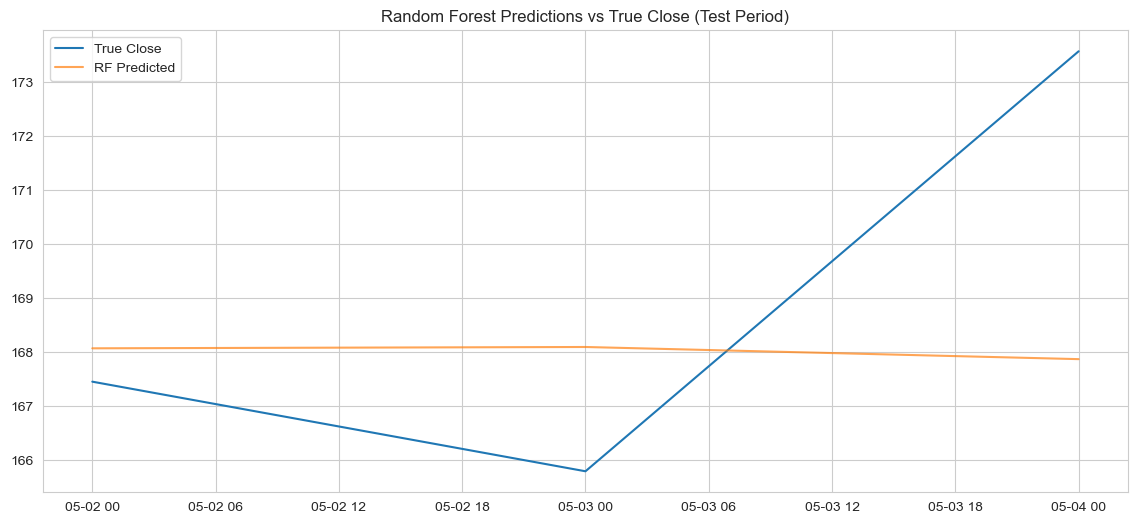

In [42]:
data = res['data']
split_idx = res['split_idx']
y_test = res['rf']['y_test']
y_pred = res['rf']['y_pred']
dates_test = data['Date'].iloc[split_idx:]
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test, label='True Close', color='tab:blue')
plt.plot(dates_test, y_pred, label='RF Predicted', color='tab:orange', alpha=0.7)
plt.title("Random Forest Predictions vs True Close (Test Period)")
plt.legend()
plt.show()